<a href="https://colab.research.google.com/github/ThazSobral/tcc/blob/main/geographic_distance_tecnique.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Técnica de distância geográfica.

by: João Porto de Albuquerque

Os dados foram coletados num período de chuvas intensas que afetaram o Rio Elba na Alemanha. Para serem trabalhos em analises os foram limitados aos dias 8, 9 e 10 de junho de 2013.

## Oque há no dataset?

- **hashtags**: hashtags encontradas no tweet;
- **tweet**: mensagem;
- **created_at**: data e hora de criação;
- **X**: coordenada no eixo X;
- **Y**: coordenada no eixo Y;
- **distance_meters**: distância em metros do tweet para a bacia hidrográfica mais próxima;
- **sev_08**: nível relativo da água no dia 08;
- **sev_09**: nível relativo da água no dia 09;
- **sev_10**: nível relativo da água no dia 10;
- **flood**: se está localizado numa área afetada ou não;
- **relevance**: rótulo de relevância (de acordo com análise manual);
- **theme**: rótulo e tema (de acordo com análise manual).

## Ajuste

Primeiro fazemos todos os **ajustes** necessários para realizar o teste da técnica.

In [61]:
# Montar do drive no notebook
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


Em seguida fazemos a **importação** das primeiras **bibliotecas** e do nosso **dataset**.

In [62]:
# Importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt

# Importar dataset
df = pd.read_csv('/content/drive/My Drive/TCC_Thalles Sobral/2-dados/germany/use-data/adjusted.csv', header=0)

# Exibir os dados
# df.head()

Podemos verificar **quantos tweets há** no nosso dataframe.

In [63]:
# Mostrar quantos tweets há no nosso dataframe
print(f'Há { len(df) } tweets no total.')

Há 60524 tweets no total.


## Identificando regiões afetadas

1. As **características** dos **eventos** são definidos com base no **modelo digital de elevação** e os **dados oficiais** (ou seja, de sensores).
2. A identificação das **áreas de captação** foi feita utilizando um conjunto de ferrametas **ArcHydro** para ArcGIS. 
  * Primeiramente foram definidos os **canais de drenagem**, o que resultou em dados vetorias.
  * E por fim as **áreas de captação** foram identificadas utilizando as junções do rio, que foram definidas utilizando o arquivo vetorial de canal de drenagem.
3. O **calculando o nível relativo da água** (ou severidade da inundação) foi baseado na medição de 185 estações. Esse cálculo foi feito **seguindo a definiçao** a baixo:
~~~
relative_level = nível médio relativo
max_level = nível máximo de água diária
mean_level = nível médio de água da enchente (total)
~~~
`relative_level = max_level - mean_level`

> Em caso de **valores negativos** pode indicar que a estação **não foi afetada**, o que **valores positivos** podem indicar **o contrário**.

> Em caso de **mais de uma estação na mesma bácia hidrográfica**, o nível relativo de água **é cálculado somando o valor relativo de cada estação** e depois **calculada a média aritmética do conjunto**. Onde esse resultado definirá se a bácia foi afetada ou não.


In [64]:
# faz a média dos valores de severidade e atribui a uma nova coluna
df['sev'] = df[['sev_08', 'sev_09', 'sev_10']].mean(axis=1)

## Coletando informações de mídia social (Twitter)

Essa etapa se dividi nas seguintes etapas:
* Filtragem baseada em palavras-chave;
* Análise do conteúdo, e;
* Condificação temática.

### Filtragem baseada em palavras-chave

Mas primeiro precisamos **remover as colunas que não seram  utilizadas**

In [65]:
# remover colunas
df = df.drop(columns=['hashtag'])

> Antes filtrar o tweets por palavras-chave filtramos por campo de georreferência, ou seja, **somente tweets georreferenciados** passam para esse etapa. Isso pode ser feito na própria API do Twitter ou através de um script.

O filtro por palavras-chave considera palavras (alemão e inglês) relacionadas a eventos de inundação, como descrito a seguir:

**German**

* *hochwasser*
* *flut*
* *überschwemmung*

**Addiotional-words in German**

* *deich*
* *sandsack*

**English**

* *flood*


In [66]:
# definir as palavras em inglês
key_words_english = ['flood']

# definir as palavras em alemão
key_words_german = ['hochwasser',
                     'flut',
                     'überschwemmung']

# definir as palavras adicionais em alemão
key_addiotional_words_german = ['deich',
                                'sandsack']

# combinar palavras-chave
key_words = key_words_english + key_words_german + key_addiotional_words_german

In [67]:
# definir função para retornar somente aos tweets que contém as palavras-chaves
def select_tweets_with_key_words (df):
  return df[df.tweet.str.contains('|'.join(key_words), na=False)]

In [68]:
# chamar a função para selecionar os tweets passando o dataframe completo
tweets_with_key_words = select_tweets_with_key_words(df)

# mostrar a quantidade de tweets que foram encontrados dentro do dataframe
print(f'Foram encontrados {len(tweets_with_key_words)} tweets contendo as palavras-chave definidas.')

# mostrar tweets que foram encotrados entro do dataframe
# tweets_with_key_words

Foram encontrados 405 tweets contendo as palavras-chave definidas.


### Análise de conteúdo

> **Só** são analisados os **tweets que contém** as **palavras-chave**.

Os tweets são **analisados e rotulados manualmente** (por três pesquisadores) dentro de **três classes**:
* (0) - fora do tópico;
* (1) - no tópico, mas não relevante, e;
* (2) - no tópico e relevante.

> O **tweet no tópico** (nesse trabalha) é aquele que se **refere ao evento** de inundação, mas **não contém informações relevantes**. 

> O **tweet relevante** (nesse trabalha) é definido como, aquele que **contém informações** que possam **contribuir para a consciência situacional**, ou seja, que pode ser útil para outras pessoas e/ou agências.

In [69]:
# adicionar uma variável para cada rótulo da análise de conteúdo
topic_out = len(tweets_with_key_words[(tweets_with_key_words['relevance'] == 0)])
topic_in = len(tweets_with_key_words[(tweets_with_key_words['relevance'] == 1)])
topic_in_and_relevance = len(tweets_with_key_words[(tweets_with_key_words['relevance'] == 2)])
# topic_out = len(df.loc[(df['relevance'] == 0)])
# topic_in = len(df.loc[(df['relevance'] == 1)])
# topic_in_and_relevance = len(df.loc[(df['relevance'] == 2)])

# exibir os rótulos com as respectivas quantias de tweets
print(f'''
 - fora do tópico: {topic_out};
 - no tópico: {topic_in}, e;
 - no tópico e relevante: {topic_in_and_relevance}
''')


 - fora do tópico: 35;
 - no tópico: 187, e;
 - no tópico e relevante: 183



In [70]:
# exibir todos os tweets rotulados como no tópico
print(f'No geral são {topic_in + topic_in_and_relevance} tweets marcados como no tópico.')

No geral são 370 tweets marcados como no tópico.


### Codificação temática

Os tweets "no tópico", sendo relevantes ou não passaram por uma codificação que avalia seu conteúdo (também e forma manual). Essa avaliação consiste em **verificar o conteúdo e rotular o tweet** dentro das seguintes classe
* (0) - other;
* (1) - volunteer actions;
* (2) - media reports;
* (3) - traffic conditions;
* (4) - first-hand observations;
* (5) - official actions, e;
* (6) - infrastructure damage;

In [71]:
# adicionar uma variável para cada rótulo da codificação temática
outhers = len(tweets_with_key_words[(tweets_with_key_words['theme']) == 0])
media_report = len(tweets_with_key_words[(tweets_with_key_words['theme']) == 1])
traffic_condition = len(tweets_with_key_words[(tweets_with_key_words['theme']) == 2])
firsthand_observation = len(tweets_with_key_words[(tweets_with_key_words['theme']) == 3])
official_action = len(tweets_with_key_words[(tweets_with_key_words['theme']) == 4])
damage_to_infrastruture = len(tweets_with_key_words[(tweets_with_key_words['theme']) == 5])
volunteer_action = len(tweets_with_key_words[(tweets_with_key_words['theme']) == 6])

# outhers = len(df[(df['theme']) == 0])
# media_report = len(df[(df['theme']) == 1])
# traffic_condition = len(df[(df['theme']) == 2])
# firsthand_observation = len(df[(df['theme']) == 3])
# official_action = len(df[(df['theme']) == 4])
# damage_to_infrastruture = len(df[(df['theme']) == 5])
# volunteer_action = len(df[(df['theme']) == 6])

# exibir a quantidade de tweets que são rotulados conforme a codificação temática
print(f'''
 - ação voluntaria: {volunteer_action}
 - relatório de mídia: {media_report}
 - condição de tráfego: {traffic_condition}
 - observação em primeira mão: {firsthand_observation}
 - ação oficial: {official_action}
 - dano a infraestrutura: {damage_to_infrastruture}
 - outros: {outhers}''')


 - ação voluntaria: 9
 - relatório de mídia: 71
 - condição de tráfego: 54
 - observação em primeira mão: 26
 - ação oficial: 69
 - dano a infraestrutura: 21
 - outros: 155


### Estabelecer relações geográficas entre tweets e os eventos

Para estabelecer a **relação de proximidade** para cada tweet é realizado um cálculo de resulta na **distância geográfica** (em metros) entre o **tweet e a bacia hidrográfica** mais próxima.

> tweets localizados **dentro da área** das bacias afetadas têm a **distância igual a 0m**.

> a relação de **gravidade** (severidade) é igual ao **nível relativo da água** da bacia que o tweet está localizado.

In [72]:
# adicionando variável com quantidade e tweets entro das bacias
tweets_within_the_affected_basins = len(df[df['distance_meters'] == 0])

# exibir quantidade de tweets que estão dentro das bacias
print(f'São {tweets_within_the_affected_basins} tweets localizados dentro da bacia afetada')

São 1577 tweets localizados dentro da bacia afetada


## Analisando as relações geográficas entre as informações sobre os eventos e as mensagens da mídia social

Os objetivos dessa análise são dois:
* identificar **padrões espaciais** na ocorrência de tweets "no tópico" que podem estar **associados** à **distância** e o **nível relativo de água**, e;
* explorar mais as **possíveis diferenças** entre os **padrões de origem** e as **codificações dos tweets** no tópico.

> De acordo com o trabalho original foi constatado que há uma **maior probabilidade** de **tweets no tópico** ao redor das **bacias com níveis de água mais altos** comparados com bacias de níveis de água mais baixos.

> Para essa análise foram **utilizados** apenas tweets localizados **dentro de uma distância de 100 km** de bacias afetadas.

In [73]:
# filtra apenas os tweets com distancia menor ou igual a 100000 m (100 km)
tweets_within_distance = df[df['distance_meters'] <= 100000]

# separa os tweets fora do tópico
topic_out = tweets_within_distance[tweets_within_distance['relevance'] == 0]
# separa os tweets com relevancia 1 (no tópico)
topic_in = tweets_within_distance[tweets_within_distance['relevance'] == 1]
# separa os tweets com relevancia 2 (no tópico e relevante)
topic_in_and_relevance = tweets_within_distance[tweets_within_distance['relevance'] == 2]
# concatena os tweets
tweets_on_topic = pd.concat([topic_in, topic_in_and_relevance])
# embaralha os tweets para evitar viés
tweets_on_topic = tweets_on_topic.sample(frac=1).reset_index(drop=True)

print(f'Há {len(tweets_on_topic)} tweets no tópico e {len(topic_out)} tweets fora do tópico.')

Há 306 tweets no tópico e 27424 tweets fora do tópico.


> Essa análise é realizada em **tweets no tópico** e **dentro do buffer de 100 km** (resultando 320 no trabalho original).

Nessa etapa é utilizado **GAM** (Generalized Aritmetic Model) com um **link logísitico** e **dois preditores** (**nível relativo de água** em metros e **log de base 10 da distância euclidiana** em quilometros para a **bacia mais próxima afetada**).

> Para **evitar resultados excessivamente influenciados** por valores extremos, foram feitos a seguitens alterações:
> * nível relativo da água entre + 1m e -1m;
> * distancias < 10km recebem 10km (antes de calcular o logaritmo).

In [74]:
''' 
para mais informações:
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MaxAbsScaler.html
'''
# importe bibliotecas necessárias
import numpy as np
from sklearn.preprocessing import MaxAbsScaler

# extrai valores de severidade (níveis relativos de água) de cada dia
# sev_08 = tweets_on_topic['sev_08'].values
# sev_09 = tweets_on_topic['sev_09'].values
# sev_10 = tweets_on_topic['sev_10'].values
sev = tweets_within_distance['sev'].values

# concatene todos os valores de severidade coletados
# sev = np.concatenate((sev_08, sev_09, sev_10))

# instancia do modelo para normalização
model = MaxAbsScaler()
# treine o modelo para realizar normalização com esses valores
model.fit(sev.reshape(-1, 1))

# transforme os valores de acordo com o modelo
'''
convertendo os arrays em 2D (porque o modelo só funciona com 2D)
'''
# sev_08 = model.transform(sev_08.reshape(-1,1))
# sev_09 = model.transform(sev_09.reshape(-1,1))
# sev_10 = model.transform(sev_10.reshape(-1,1))
sev = model.transform(sev.reshape(-1,1))

# exibir os valores das matrizes
# print(f'Sev08: {sev08}\nSev09: {sev09}\nSev10: {sev10}')

# conveter os arrays para 1D novamente
# sev_08 = sev_08.flatten()
# sev_09 = sev_09.flatten()
# sev_10 = sev_10.flatten()
sev = sev.flatten()

# atribuir os valores ajustados no dataframe
# tweets_on_topic['sev_08'] = sev_08
# tweets_on_topic['sev_09'] = sev_09
# tweets_on_topic['sev_10'] = sev_10
tweets_within_distance['sev'] = sev

# exibir os valores dos arrays
# print(f'Sev08: {sev_08}\nSev09: {sev_09}\nSev10: {sev_10}')
# print(f'Sev: {sev}')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [75]:
# função de substituição de valores que são menores que 10000 m (10 km)
def replace_value(value):
  limit = 10000
  if value < limit:
    return limit
  return value

# atribui a todas as distancias que forem menores ou iguais a 10000 (10 km) atribui 10000
tweets_within_distance['distance_meters'] = tweets_within_distance['distance_meters'].map(replace_value)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [76]:
# importar biblioteca necessária
import math

# criar nova coluna com valores da distancia com log 10
tweets_within_distance['distance_log'] = tweets_within_distance['distance_meters'].apply(lambda x: math.log10(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


O GAM implementado (do pacote R 'mgcv') **ajusta automaticamente de liberdade** efetivos do spline com um processo de validação cruzada generalizado, além de ser um 'bam' que é apropriado para **grandes conjuntos de dados**.

Foram ajustados **GAMs alternativos** que representem os preditores como termos **aditivos** (duas splines univariadas) ou **interativos** (uam spline bivariada). Para o modelo **aditivo** foi aplicado um **limite de liberdade** de **3 graus**, e para o modelo **interativo** um **limite** de **5 graus**, sendo a finalidade desses objetivos **evitar oscilações excessivas** nos splines resultantes.

In [77]:
degree = [3,5]

Além dos GAMs serem utilizados por causa dos recursos visuais, mas também têm a função de **calcular** as **razões de chance e riscos relativos** (proporção de probabilidades) **associados** à **distância** e **nível relativo da água**. 

> O odds ratios (probablidade de relação) e risco relativo são calculados para **<= 10 km** versus **30 km** de distância das áreas afetadas, e para um nível relativo da água **+0,75 m** versus **-0,75 m** mantendo o **outro preditor constante**.
> Para esse cálculo é feito operando em cima de um preditor em diferentes níveis do outro preditor.
~~~
 - gravity_ratio = relação de gravidade
 - nível de água relativa da captura na localização do tweet
~~~
`gravity_ratio[tweet] = relative_level[tweet]`

> É aplicao o **bootstrap** de bloco espacial para obter **intervalos de confiança** percentil no nível de **95%**.
> O processo de **bootstrap** foi **repetido 2500 vezes** a fim de obter os **intervalos de confiança** de percentil de **95%**.

Exploração dos tweets para modelar a **probabilidade** de um **tweet no tópico pertencer a um subtipo** específico.

> O modelo foi ajustado para **identificar padrões tweets como relevantes** (resultando 169 no trabalho original) **versus** os ***não relevantes** em relação a **distância** e ao **nível relativo da água**. Isso foi realizado para responder a **questão** dos **tweets mais relevantes** são fortemente **concetrado**s nas proximidades das **áreas afetadas** ou em **bacias** com **níveis relativos de água** mais **elevados**.

Cálculo da **relação geográfica** com o **tweet**
~~~
 - tweet_interface = relação do tweet
 - tweet_localization = localização do tweet
 - hydrographic_basin = bacia hidrográfica afetada
~~~
`tweet_interface = tweet_localization - hyrographic_basin`

> Como a amostra é pequena, somente **GAMs sem termo de interação** foram considerados, e apenas **resumos gráficos** e **numéricos básicos** são fornecidos para **análise exploratória** desses padrões.

In [78]:
'''
para mais informações de correlação:
https://medium.com/brdata/correla%C3%A7%C3%A3o-direto-ao-ponto-9ec1d48735fb
'''
# medir a correlação entre a distancia e o grau de severidade
# corr_dist_sev08 = df['distance_meters'].corr(df['sev_08'])
# corr_dist_sev09 = df['distance_meters'].corr(df['sev_09'])
# corr_dist_sev10 = df['distance_meters'].corr(df['sev_10'])
corr_dist_sev = df['distance_meters'].corr(df['sev'])

# print(f'Graus de correlação de distancia para os dias:\n08 = {corr_dist_sev08}\n09 = {corr_dist_sev09}\n10 = {corr_dist_sev10}')
print(f'Graus de correlação de distancia e a severidade: {corr_dist_sev}')

Graus de correlação de distancia e a severidade: -0.44566766199791147


### PyGAM (Classificação)

In [79]:
''' Documentação 
https://pygam.readthedocs.io/en/latest/notebooks/quick_start.html#Fit-a-Model
Olhar artigos:
https://codeburst.io/pygam-getting-started-with-generalized-additive-models-in-python-457df5b4705f
e depois
https://medium.com/just-another-data-scientist/building-interpretable-models-with-generalized-additive-models-in-python-c4404eaf5515
'''
# Teste PyGAM
!pip install pygam

In [80]:
# importe a biblioteca necessária
from pygam import LogisticGAM

# importe a biblioteca necessária para trabalhar com conjunto de treino e teste
import numpy as np
from sklearn.model_selection import train_test_split

X = np.array(tweets_within_distance[['distance_log', 'sev']])
y = np.array(tweets_within_distance[['flood']])

# separar conjunto de treino e teste
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=100)

# treina o modelo utlizando todos os dados de treino
gam = LogisticGAM().fit(x_train, y_train)
# treina o modelo utlizando todos os dados dentro de 100 km
# gam = LogisticGAM().fit(X, y)
gam.summary()

# verificar a acuracia com todos os dados de treino
gam.accuracy(x_train, y_train)
# verificar a acuracia com todos os dados dentro de 100 km
# gam.accuracy(X, y)

LogisticGAM                                                                                               
=============================================== ==========================================================
Distribution:                      BinomialDist Effective DoF:                                     16.6213
Link Function:                        LogitLink Log Likelihood:                                  -989.3414
Number of Samples:                        22184 AIC:                                             2011.9253
                                                AICc:                                            2011.9549
                                                UBRE:                                               2.0913
                                                Scale:                                                 1.0
                                                Pseudo R-Squared:                                   0.3176
Feature Function                  Lam

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 



0.9879192210602236

In [81]:
# importar bibliotecas necessárias
from sklearn.metrics import accuracy_score, log_loss

# prever a acuracia do modelo
predictions = gam.predict(x_test)
print("Accuracy: {} ".format(accuracy_score(y_test, predictions)))
# prever a probabilidade de perda
probas = gam.predict_proba(x_test)      
print("Log Loss: {} ".format(log_loss(y_test, probas)))

Accuracy: 0.9906238730616661 
Log Loss: 0.03845200969132748 


In [82]:
# definir o termo de penalização
lambda_ = 0.6
# definir a função
constraints = None
# criar modelo 
gam = LogisticGAM(constraints=constraints, 
        lam=lambda_,
        n_splines=10).fit(X, y)

In [83]:
# criar modelo logistico atribuindo 10 splines
log_gam = LogisticGAM(n_splines=10).gridsearch(X, y)

100% (11 of 11) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


<Figure size 432x288 with 0 Axes>

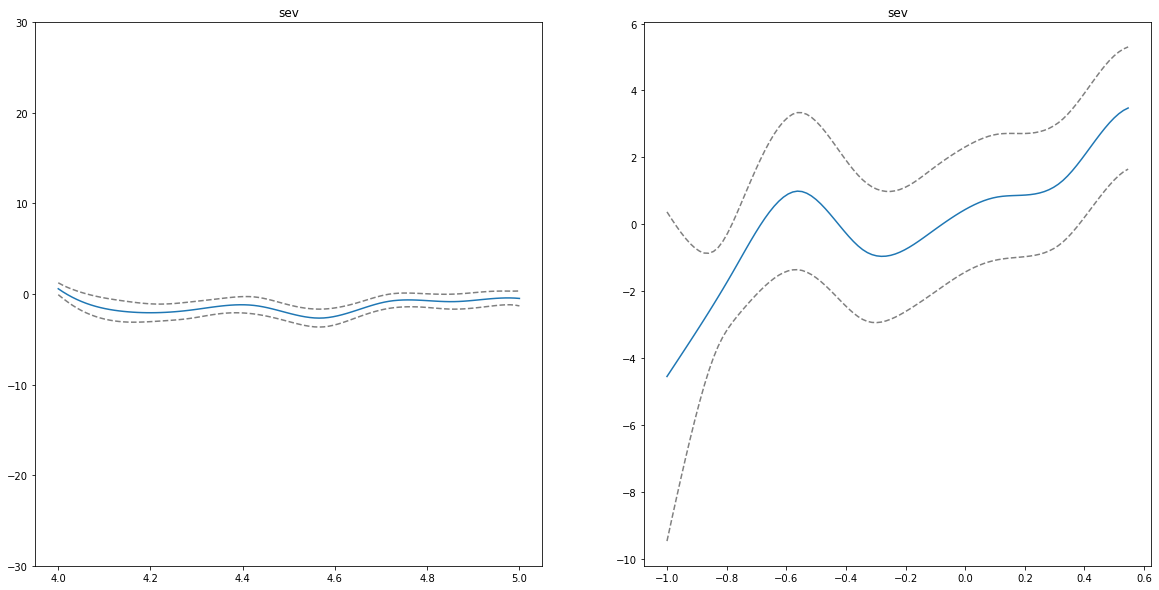

In [91]:
# trabalhar com plotagem para o modelo
titles = tweets_within_distance[['distance_log', 'sev']]
titles = titles.columns[1:2]
plt.figure()
fig, axs = plt.subplots(1,2,figsize=(20, 10))
for i, ax in enumerate(axs):
    XX = log_gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], log_gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], log_gam.partial_dependence(term=i, X=XX, width=.95)[1], c='gray', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i-1])

# TESTES

### PyGAM (regressão)

In [92]:
from pygam import LinearGAM, s
import numpy as np

lin_gam = LinearGAM(s(0, n_splines=4) + s(1, n_splines=5)).gridsearch(x_train, y_train)

100% (11 of 11) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


<Figure size 432x288 with 0 Axes>

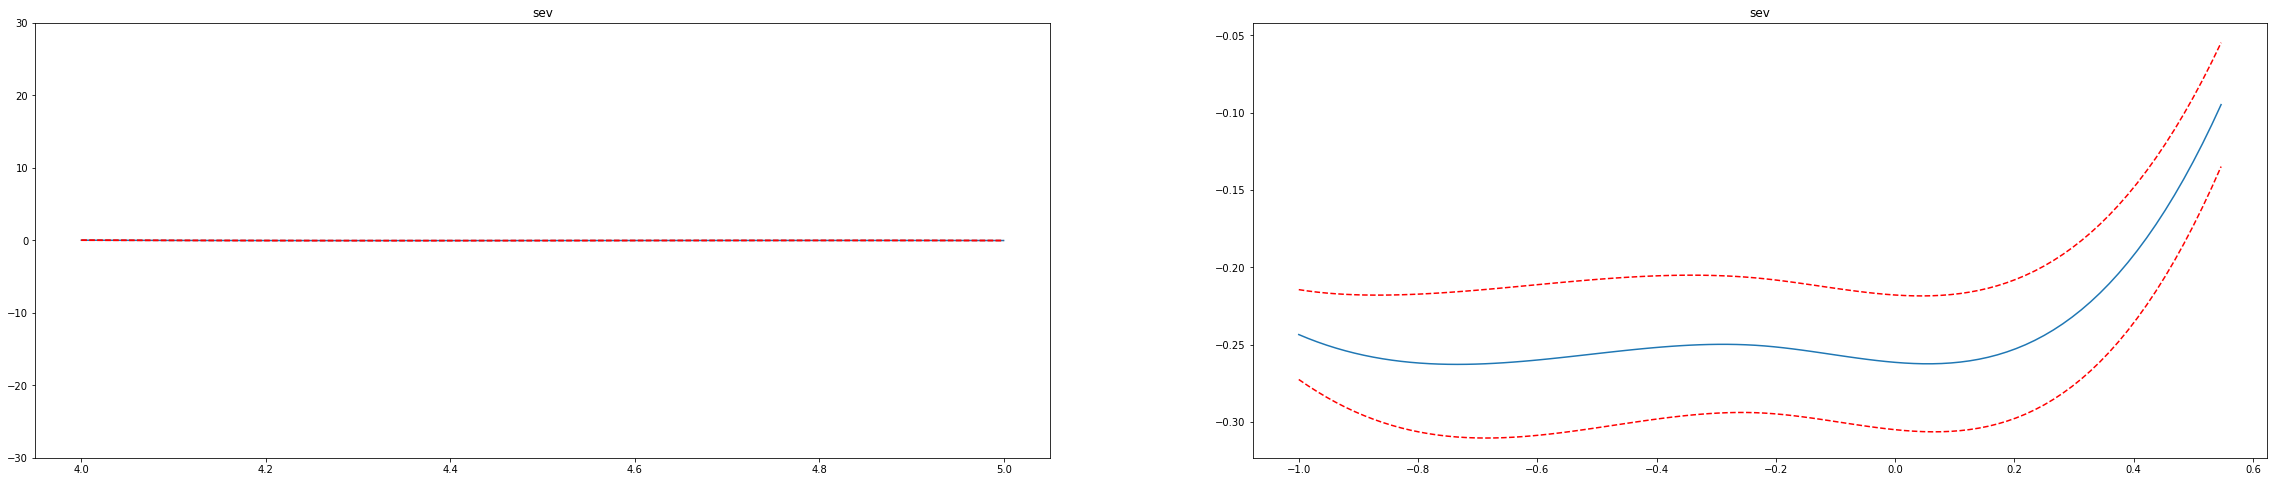

In [93]:
plt.figure()
fig, axs = plt.subplots(1,2,figsize=(40, 8))
for i, ax in enumerate(axs):
    XX = gam.generate_X_grid(term=i)
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX))
    ax.plot(XX[:, i], gam.partial_dependence(term=i, X=XX,   width=.95)[1], c='r', ls='--')
    if i == 0:
        ax.set_ylim(-30,30)
    ax.set_title(titles[i-1])

### Statsmodels.gam

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flood   No. Observations:                27730
Model:                         GLMGam   Df Residuals:                    27709
Model Family:                Gaussian   Df Model:                        20.00
Link Function:               identity   Scale:                        0.010326
Method:                         PIRLS   Log-Likelihood:                 24069.
Date:                Tue, 10 Nov 2020   Deviance:                       286.12
Time:                        01:30:18   Pearson chi2:                     286.
No. Iterations:                     3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.0666      0.004     18.381   

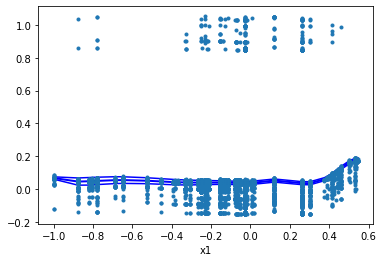

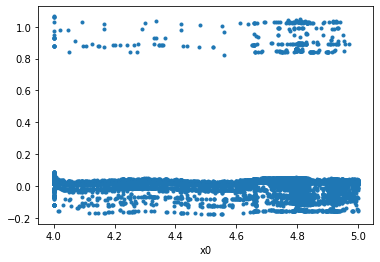

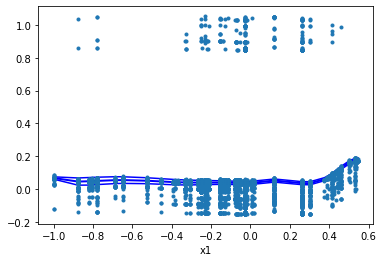

In [89]:
from statsmodels.gam.api import GLMGam, BSplines

x_spline = X

bs = BSplines(x_spline, df=[12, 10], degree=[3,5])

gam_bs = GLMGam.from_formula('flood ~ distance_log + sev', data=tweets_within_distance, smoother=bs)

res_bs = gam_bs.fit()

print(res_bs.summary())

res_bs.plot_partial(0, cpr=True)
res_bs.plot_partial(1, cpr=True)